# edges2shoes と facades から実験用データを作成する

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import cv2
import re
from tqdm import tqdm_notebook as tqdm
from collections import deque
import random

In [2]:
# path
edges2shoes_dir = pathlib.Path("/mnt/data/pix2pix/edges2shoes/")
facades_dir = pathlib.Path("/mnt/data/pix2pix/facades/")
assert edges2shoes_dir.exists() and facades_dir.exists()

In [3]:
import math


def make_grid(images):
    """make a grid of images
    Args:
        images : shape = (N, H, W, C)
    
    Returns:
        grid_image : shape = (H2, W2, C)
    """
    total = images.shape[0]
    cols = math.ceil(np.sqrt(total))
    rows = math.ceil(total / cols)
    height, width = images.shape[1], images.shape[2]
    grid_image = np.zeros((height * rows, width * cols, images.shape[-1]),
                          dtype=images.dtype)

    for index, image in enumerate(images):
        i = index // cols
        j = index % cols
        grid_image[height * i:height * (i + 1), width * j:width *
                   (j + 1)] = image
    return grid_image

def load_images(img_path):
    imgs = cv2.cvtColor(cv2.imread(str(img_path[0])),
                        cv2.COLOR_BGR2RGB)[np.newaxis, :]
    for path in img_path[1:]:
        img = cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)[np.newaxis, :]
        imgs = np.concatenate((imgs, img))
    return imgs

def plot_data(index_list, df, figsize=(6, 8), wspace=0.05, fontsize=10):
    A_path = df.loc[index_list, "A_path"].tolist()
    B_path = df.loc[index_list, "B_path"].tolist()

    A = make_grid(load_images(A_path))
    B = make_grid(load_images(B_path))

    fig, ax = plt.subplots(1, 2, figsize=figsize)
    ax[0].imshow(A)
    ax[0].set_title("A", fontsize=fontsize)
    ax[0].set_axis_off()
    ax[1].imshow(B)
    ax[1].set_title("B", fontsize=fontsize)
    ax[1].set_axis_off()
    plt.subplots_adjust(wspace=wspace)

    return fig

## edges2shoes について

In [4]:
train_dir = edges2shoes_dir / "train"
val_dir = edges2shoes_dir / "val"
assert train_dir.exists() and val_dir.exists()

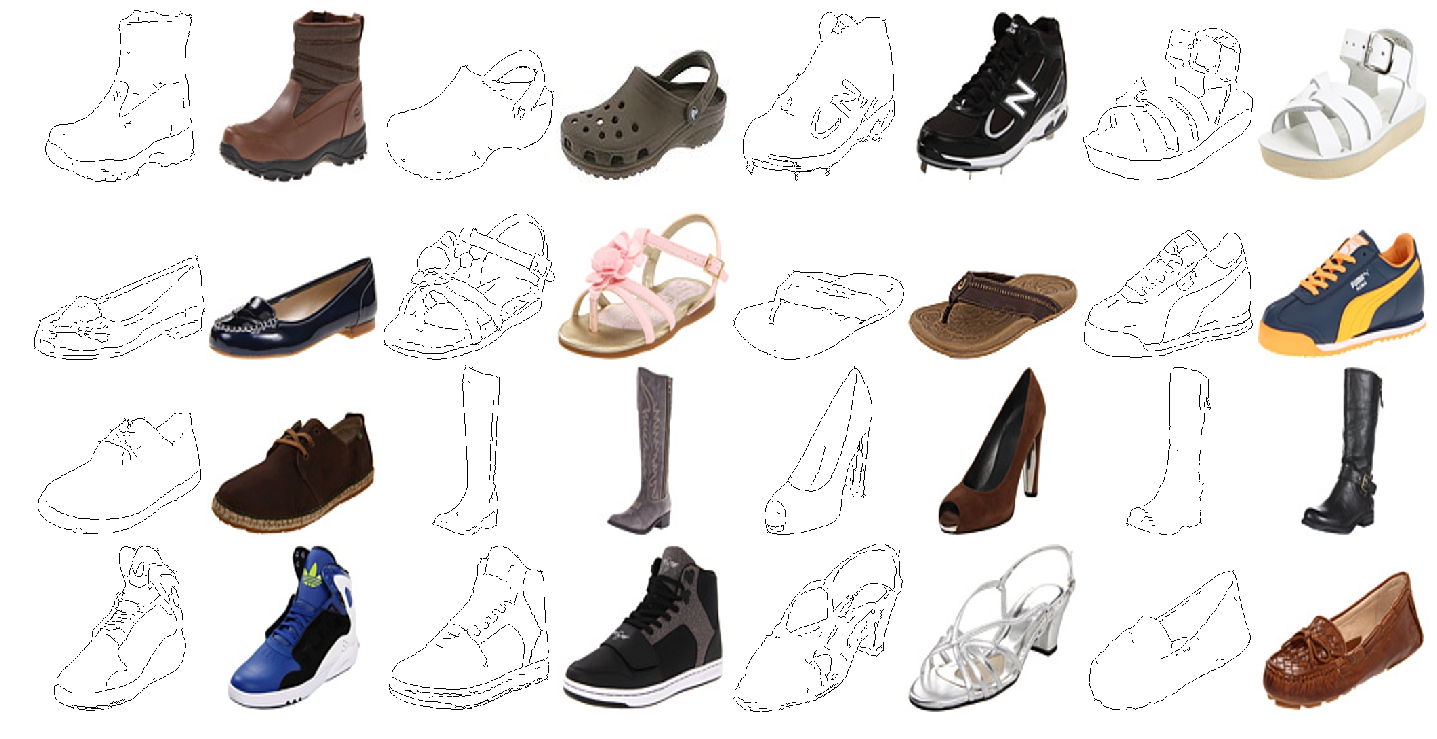

In [5]:
# 画像を表示してみる
fig, axes = plt.subplots(4, 4, figsize=(25, 13))
for path, ax in zip(train_dir.glob("*.jpg"), axes.flatten()):
    img = cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)
    #print(img.shape)
    ax.imshow(img)
    ax.set_axis_off()
plt.subplots_adjust(wspace=0.01, hspace=0.01)
fig.savefig("/mnt/tlab-nas/yohei/pix2pix/edges2shoes/pre_example.png",
             bbox_inches="tight",
             pad_inches=0)

### 真ん中を分割する

14289_A.png 14289_AB
905_A.png 905_AB
10725_A.png 10725_AB
645_A.png 645_AB
48525_A.png 48525_AB
20987_A.png 20987_AB
2467_A.png 2467_AB
48851_A.png 48851_AB
16511_A.png 16511_AB
40876_A.png 40876_AB
26246_A.png 26246_AB
35162_A.png 35162_AB
25458_A.png 25458_AB
2631_A.png 2631_AB
12219_A.png 12219_AB
24460_A.png 24460_AB


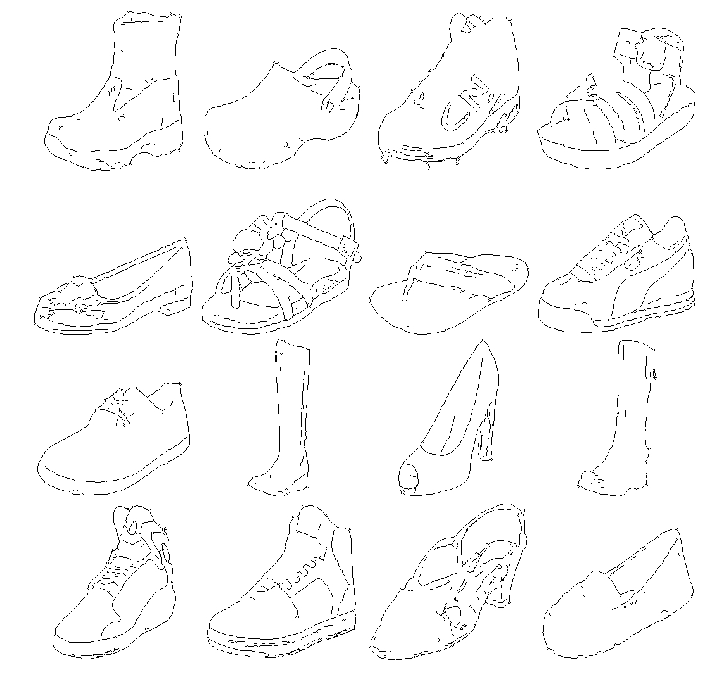

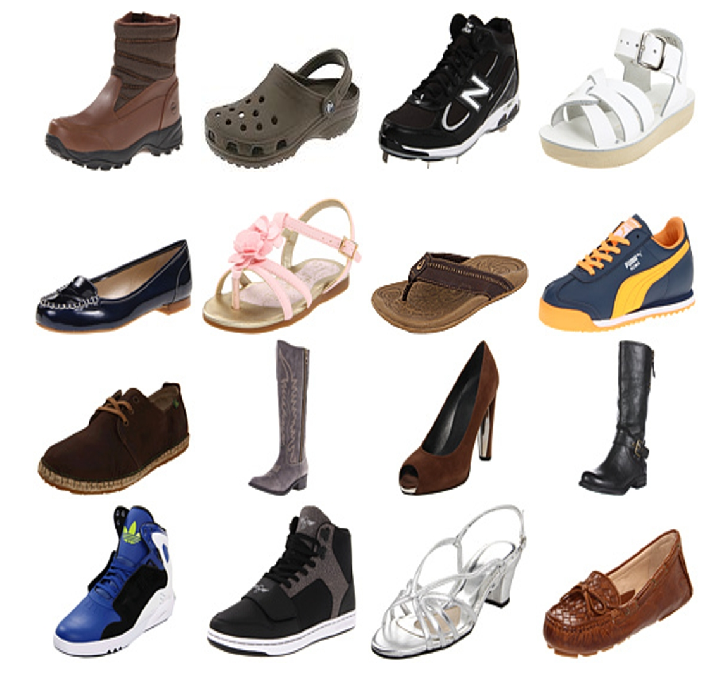

In [6]:
# 分割して画像を表示してみる
fig1, axes1 = plt.subplots(4, 4, figsize=(12, 12))
fig2, axes2 = plt.subplots(4, 4, figsize=(12, 12))
for path, ax1, ax2 in zip(train_dir.glob("*.jpg"), axes1.flatten(),
                          axes2.flatten()):
    img = cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)
    num = re.split("_", path.stem)[0]
    print(num + "_A.png", path.stem)
    ax1.imshow(img[:, :256])
    ax1.set_axis_off()
    ax2.imshow(img[:, 256:])
    ax2.set_axis_off()
    assert img[:, :256].shape == img[:, 256:].shape
fig1.subplots_adjust(wspace=0.005, hspace=0.01)
fig2.subplots_adjust(wspace=0.005, hspace=0.01)
plt.show(fig1)
plt.show(fig2)
fig1.savefig("/mnt/tlab-nas/yohei/pix2pix/edges2shoes/edges_example.png",
             bbox_inches="tight",
             pad_inches=0)
fig2.savefig("/mnt/tlab-nas/yohei/pix2pix/edges2shoes/photos_example.png",
             bbox_inches="tight",
             pad_inches=0)

In [7]:
# 分割する
train_dir = edges2shoes_dir / "train"
val_dir = edges2shoes_dir / "val"
for dir_ in tqdm([train_dir, val_dir]):
    edges_dir = dir_ / "edges"
    if not edges_dir.exists():
        edges_dir.mkdir()
    photos_dir = dir_ / "photos"
    if not photos_dir.exists():
        photos_dir.mkdir()
    for path in tqdm(dir_.glob("*.jpg"), total=len(list(dir_.glob("*.jpg")))):
        # 画像読み込む&分割
        img = cv2.imread(str(path))
        edge = img[:, :256]
        photo = img[:, 256:]
        assert edge.shape == photo.shape

        # 保存
        num = re.split("_", path.stem)[0]
        edge_path = edges_dir / (num + "_A.png")
        assert cv2.imwrite(str(edge_path), edge)
        photo_path = photos_dir / (num + "_B.png")
        assert cv2.imwrite(str(photo_path), photo)
        
        # 確認
        assert np.all(cv2.imread(str(edge_path)) == edge)
        assert np.all(cv2.imread(str(photo_path)) == photo)

In [8]:
# A_path と B_path のdataframe を作成
df_dir = edges2shoes_dir / "dataframe"
if not df_dir.exists():
    df_dir.mkdir()
train_dir = edges2shoes_dir / "train"
val_dir = edges2shoes_dir / "val"
for dir_, phase in tqdm(zip([train_dir, val_dir], ["train", "val"]), total=2):
    edges_dir = dir_ / "edges"
    photos_dir = dir_ / "photos"
    A_path_list = deque()
    B_path_list = deque()
    for path in tqdm(dir_.glob("*.jpg"), total=len(list(dir_.glob("*.jpg")))):
        num = re.split("_", path.stem)[0]
        edge_path = edges_dir / (num + "_A.png")
        photo_path = photos_dir / (num + "_B.png")
        assert edge_path.exists() and photo_path.exists()
        if not edge_path.is_absolute():
            edge_path = edge_path.resolve()
        if not photo_path.is_absolute():
            photo_path = photo_path.resolve()
        A_path_list.append(edge_path)
        B_path_list.append(photo_path)

    # dataframe 作成
    df = pd.DataFrame({
        "A_path": list(map(str, A_path_list)),
        "B_path": list(map(str, B_path_list))
    })
    # 確認
    for _, (A_path, B_path) in tqdm(df.iterrows(), total=len(df)):
        A_path = pathlib.Path(A_path)
        B_path = pathlib.Path(B_path)
        A_num = re.split("_", str(A_path.name))[0]
        B_num = re.split("_", str(B_path.name))[0]
        assert A_num == B_num, "Got {} vs {}".format(A_num, B_num)
    # 保存
    df.to_csv(df_dir / "{}_df.csv".format(phase), index=False)
    tmp = pd.read_csv(df_dir / "{}_df.csv".format(phase))
    assert (tmp == df).all(None)

In [9]:
df_dir = edges2shoes_dir / "dataframe"
train_df = pd.read_csv(df_dir / "train_df.csv")
val_df = pd.read_csv(df_dir / "val_df.csv")

In [10]:
train_df.head()

A_path  \
0  /mnt/data/pix2pix/edges2shoes/train/edges/1428...   
1  /mnt/data/pix2pix/edges2shoes/train/edges/905_...   
2  /mnt/data/pix2pix/edges2shoes/train/edges/1072...   
3  /mnt/data/pix2pix/edges2shoes/train/edges/645_...   
4  /mnt/data/pix2pix/edges2shoes/train/edges/4852...   

                                              B_path  
0  /mnt/data/pix2pix/edges2shoes/train/photos/142...  
1  /mnt/data/pix2pix/edges2shoes/train/photos/905...  
2  /mnt/data/pix2pix/edges2shoes/train/photos/107...  
3  /mnt/data/pix2pix/edges2shoes/train/photos/645...  
4  /mnt/data/pix2pix/edges2shoes/train/photos/485...

In [11]:
val_df.head()

A_path  \
0  /mnt/data/pix2pix/edges2shoes/val/edges/141_A.png   
1   /mnt/data/pix2pix/edges2shoes/val/edges/54_A.png   
2   /mnt/data/pix2pix/edges2shoes/val/edges/51_A.png   
3   /mnt/data/pix2pix/edges2shoes/val/edges/17_A.png   
4   /mnt/data/pix2pix/edges2shoes/val/edges/93_A.png   

                                              B_path  
0  /mnt/data/pix2pix/edges2shoes/val/photos/141_B...  
1  /mnt/data/pix2pix/edges2shoes/val/photos/54_B.png  
2  /mnt/data/pix2pix/edges2shoes/val/photos/51_B.png  
3  /mnt/data/pix2pix/edges2shoes/val/photos/17_B.png  
4  /mnt/data/pix2pix/edges2shoes/val/photos/93_B.png

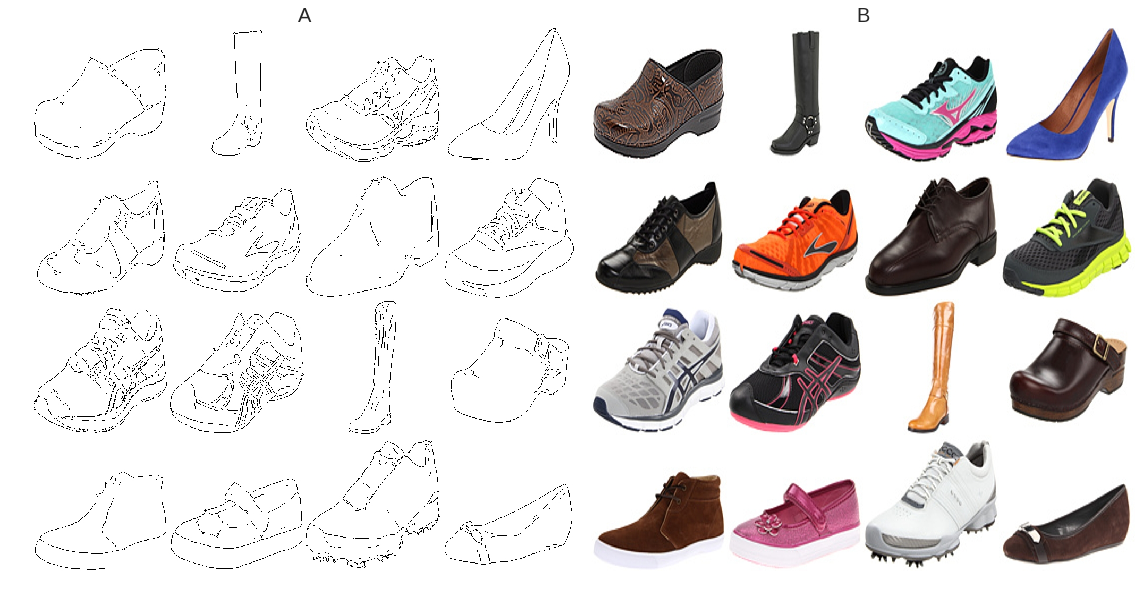

In [12]:
# 確認
index_list = random.sample(range(len(train_df)), 4*4)
plt.style.use("seaborn-white")
fig = plot_data(index_list, train_df, figsize=(20, 10), fontsize=20, wspace=0.001)

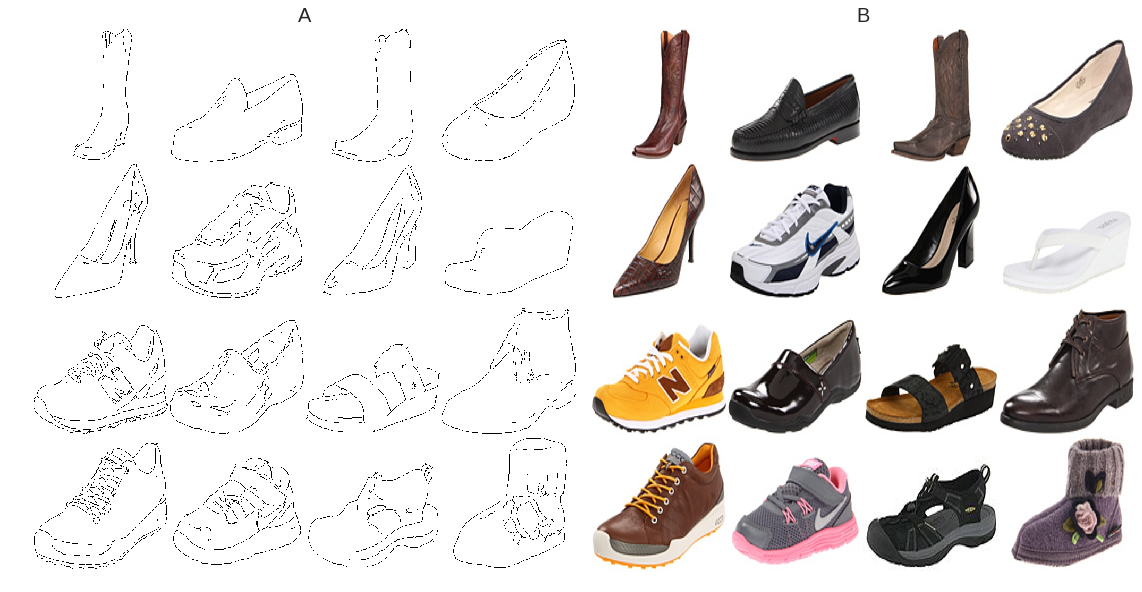

In [13]:
# 確認
index_list = random.sample(range(len(val_df)), 4*4)
plt.style.use("seaborn-white")
fig = plot_data(index_list, val_df, figsize=(20, 10), fontsize=20, wspace=0.001)

## facades について

In [14]:
train_dir = facades_dir / "train"
val_dir = facades_dir / "val"
assert train_dir.exists() and val_dir.exists()

(256, 512, 3)
(256, 512, 3)
(256, 512, 3)
(256, 512, 3)
(256, 512, 3)
(256, 512, 3)
(256, 512, 3)
(256, 512, 3)
(256, 512, 3)
(256, 512, 3)
(256, 512, 3)
(256, 512, 3)
(256, 512, 3)
(256, 512, 3)
(256, 512, 3)
(256, 512, 3)


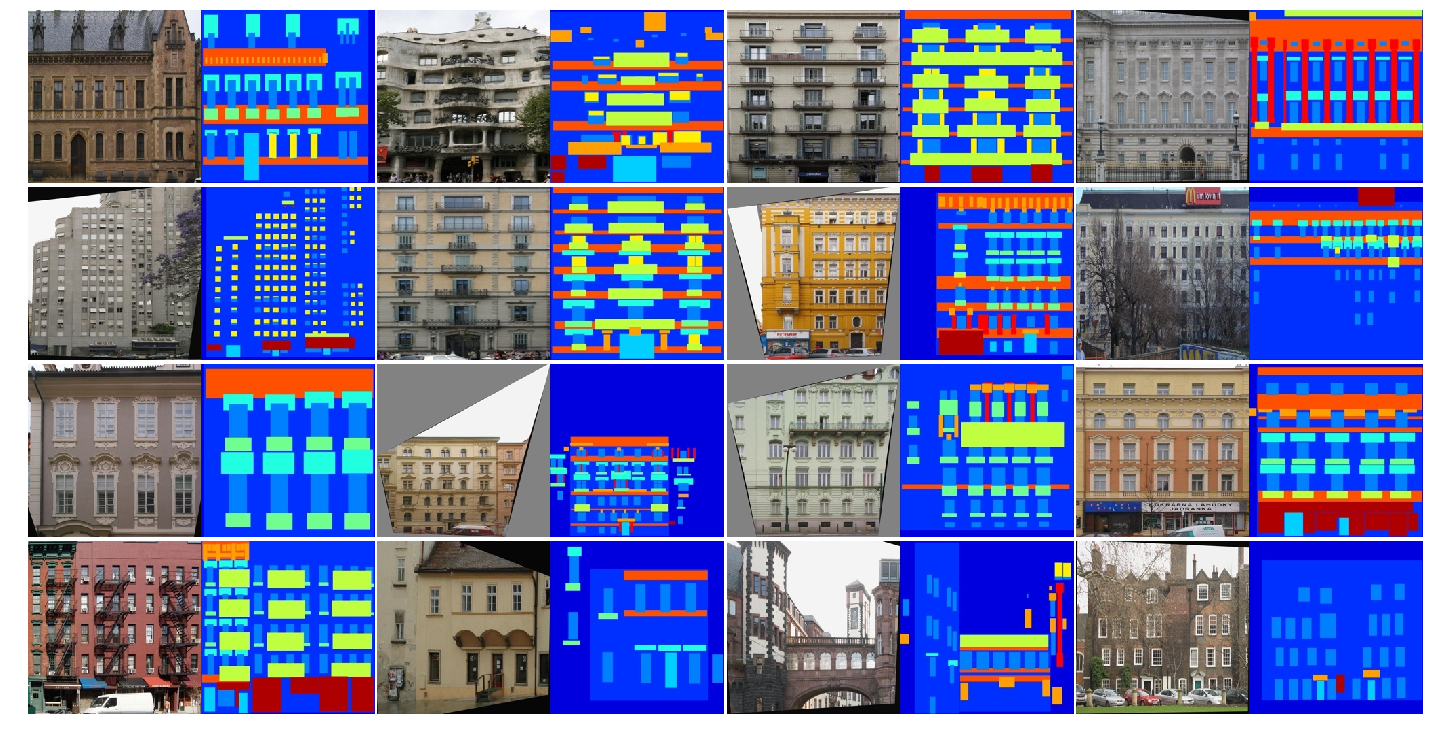

In [15]:
# 画像を表示してみる
fig, axes = plt.subplots(4, 4, figsize=(25, 13))
for path, ax in zip(train_dir.glob("*.jpg"), axes.flatten()):
    img = cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)
    print(img.shape)
    ax.imshow(img)
    ax.set_axis_off()
plt.subplots_adjust(wspace=0.01, hspace=0.01)
fig.savefig("/mnt/tlab-nas/yohei/pix2pix/facades/pre_example.png",
             bbox_inches="tight",
             pad_inches=0)

96_A.png 96
33_A.png 33
266_A.png 266
57_A.png 57
340_A.png 340
99_A.png 99
398_A.png 398
366_A.png 366
218_A.png 218
231_A.png 231
208_A.png 208
305_A.png 305
131_A.png 131
373_A.png 373
47_A.png 47
14_A.png 14


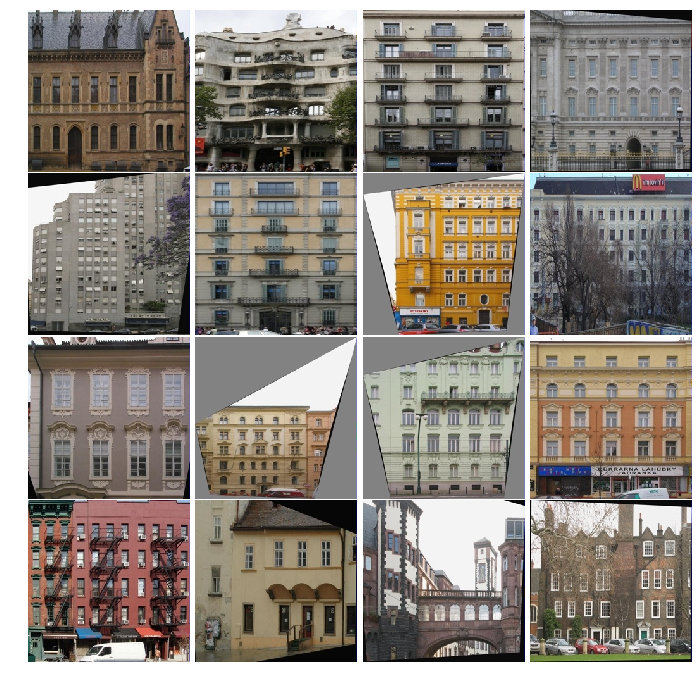

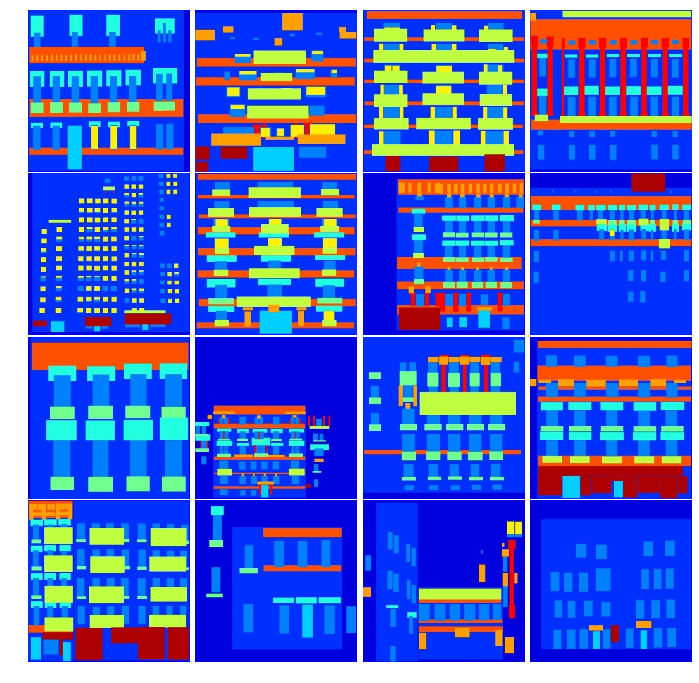

In [16]:
# 分割して画像を表示してみる
fig1, axes1 = plt.subplots(4, 4, figsize=(12, 12))
fig2, axes2 = plt.subplots(4, 4, figsize=(12, 12))
for path, ax1, ax2 in zip(train_dir.glob("*.jpg"), axes1.flatten(),
                          axes2.flatten()):
    img = cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)
    num = path.stem
    print(num + "_A.png", path.stem)
    ax1.imshow(img[:, :256])
    ax1.set_axis_off()
    ax2.imshow(img[:, 256:])
    ax2.set_axis_off()
    assert img[:, :256].shape == img[:, 256:].shape
fig1.subplots_adjust(wspace=0.005, hspace=0.01)
fig2.subplots_adjust(wspace=0.005, hspace=0.01)
plt.show(fig1)
plt.show(fig2)
fig1.savefig("/mnt/tlab-nas/yohei/pix2pix/edges2shoes/photos_example.png",
             bbox_inches="tight",
             pad_inches=0)
fig2.savefig("/mnt/tlab-nas/yohei/pix2pix/edges2shoes/labelmap_example.png",
             bbox_inches="tight",
             pad_inches=0)

In [17]:
# 分割する
train_dir = facades_dir / "train"
val_dir = facades_dir / "val"
for dir_ in tqdm([train_dir, val_dir]):
    photos_dir = dir_ / "photos"
    if not photos_dir.exists():
        photos_dir.mkdir()
    labelmap_dir = dir_ / "labelmap"
    if not labelmap_dir.exists():
        labelmap_dir.mkdir()
    for path in tqdm(dir_.glob("*.jpg"), total=len(list(dir_.glob("*.jpg")))):
        # 画像読み込む&分割
        img = cv2.imread(str(path))
        photo = img[:, :256]
        labelmap = img[:, 256:]
        assert labelmap.shape == photo.shape

        # 保存
        num = path.stem
        labelmap_path = labelmap_dir / (num + "_A.png")
        assert cv2.imwrite(str(labelmap_path), labelmap)
        photo_path = photos_dir / (num + "_B.png")
        assert cv2.imwrite(str(photo_path), photo)
        
        # 確認
        assert np.all(cv2.imread(str(labelmap_path)) == labelmap)
        assert np.all(cv2.imread(str(photo_path)) == photo)

In [18]:
# A_path と B_path のdataframe を作成
df_dir = facades_dir / "dataframe"
if not df_dir.exists():
    df_dir.mkdir()
train_dir = facades_dir / "train"
val_dir = facades_dir / "val"
for dir_, phase in tqdm(zip([train_dir, val_dir], ["train", "val"]), total=2):
    labelmap_dir = dir_ / "labelmap"
    photos_dir = dir_ / "photos"
    A_path_list = deque()
    B_path_list = deque()
    for path in tqdm(dir_.glob("*.jpg"), total=len(list(dir_.glob("*.jpg")))):
        num = path.stem
        labelmap_path = labelmap_dir / (num + "_A.png")
        photo_path = photos_dir / (num + "_B.png")
        assert labelmap_path.exists() and photo_path.exists()
        if not labelmap_path.is_absolute():
            labelmap_path = labelmap_path.resolve()
        if not photo_path.is_absolute():
            photo_path = photo_path.resolve()
        A_path_list.append(labelmap_path)
        B_path_list.append(photo_path)

    # dataframe 作成
    df = pd.DataFrame({
        "A_path": list(map(str, A_path_list)),
        "B_path": list(map(str, B_path_list))
    })
    # 確認
    for _, (A_path, B_path) in tqdm(df.iterrows(), total=len(df)):
        A_path = pathlib.Path(A_path)
        B_path = pathlib.Path(B_path)
        A_num = re.split("_", str(A_path.name))[0]
        B_num = re.split("_", str(B_path.name))[0]
        assert A_num == B_num, "Got {} vs {}".format(A_num, B_num)
    # 保存
    df.to_csv(df_dir / "{}_df.csv".format(phase), index=False)
    tmp = pd.read_csv(df_dir / "{}_df.csv".format(phase))
    assert (tmp == df).all(None)

In [19]:
df_dir = facades_dir / "dataframe"
train_df = pd.read_csv(df_dir / "train_df.csv")
val_df = pd.read_csv(df_dir / "val_df.csv")

In [20]:
train_df.head()

A_path  \
0  /mnt/data/pix2pix/facades/train/labelmap/96_A.png   
1  /mnt/data/pix2pix/facades/train/labelmap/33_A.png   
2  /mnt/data/pix2pix/facades/train/labelmap/266_A...   
3  /mnt/data/pix2pix/facades/train/labelmap/57_A.png   
4  /mnt/data/pix2pix/facades/train/labelmap/340_A...   

                                             B_path  
0   /mnt/data/pix2pix/facades/train/photos/96_B.png  
1   /mnt/data/pix2pix/facades/train/photos/33_B.png  
2  /mnt/data/pix2pix/facades/train/photos/266_B.png  
3   /mnt/data/pix2pix/facades/train/photos/57_B.png  
4  /mnt/data/pix2pix/facades/train/photos/340_B.png

In [21]:
val_df.head()

A_path  \
0  /mnt/data/pix2pix/facades/val/labelmap/96_A.png   
1  /mnt/data/pix2pix/facades/val/labelmap/33_A.png   
2  /mnt/data/pix2pix/facades/val/labelmap/57_A.png   
3  /mnt/data/pix2pix/facades/val/labelmap/99_A.png   
4  /mnt/data/pix2pix/facades/val/labelmap/47_A.png   

                                          B_path  
0  /mnt/data/pix2pix/facades/val/photos/96_B.png  
1  /mnt/data/pix2pix/facades/val/photos/33_B.png  
2  /mnt/data/pix2pix/facades/val/photos/57_B.png  
3  /mnt/data/pix2pix/facades/val/photos/99_B.png  
4  /mnt/data/pix2pix/facades/val/photos/47_B.png

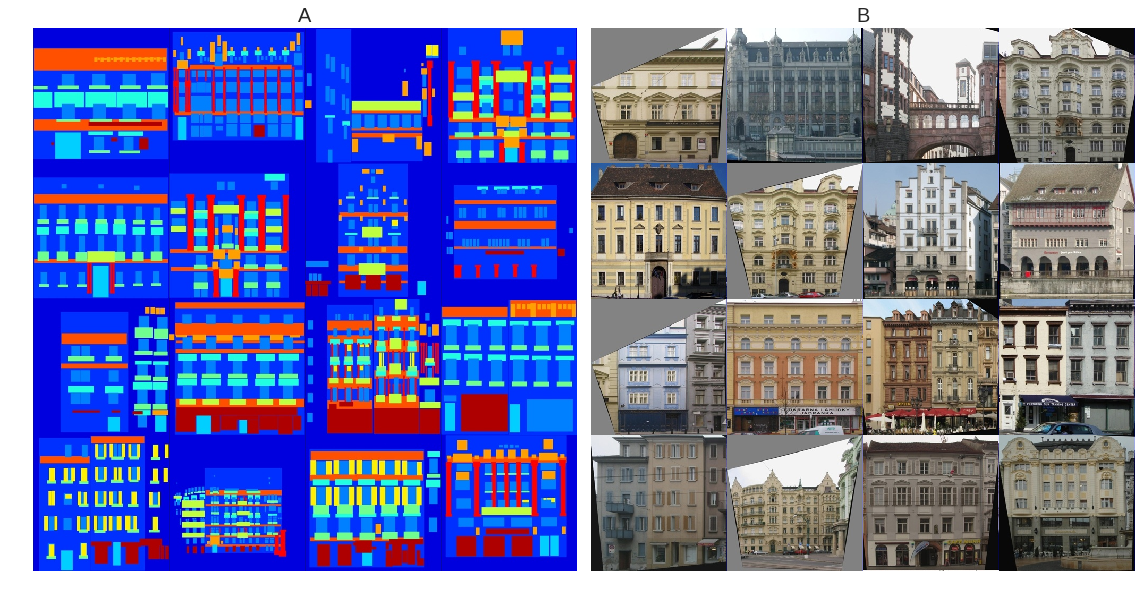

In [22]:
# 確認
index_list = random.sample(range(len(train_df)), 4*4)
plt.style.use("seaborn-white")
fig = plot_data(index_list, train_df, figsize=(20, 10), fontsize=20, wspace=0.001)

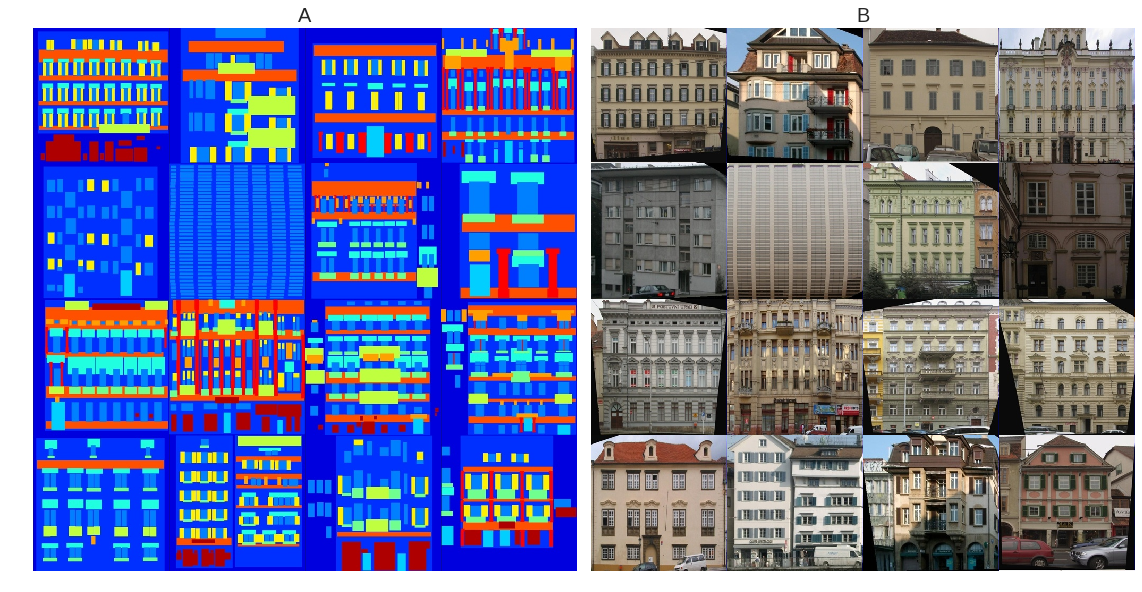

In [23]:
# 確認
index_list = random.sample(range(len(val_df)), 4*4)
plt.style.use("seaborn-white")
fig = plot_data(index_list, val_df, figsize=(20, 10), fontsize=20, wspace=0.001)